In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas
import os
import zipfile
import requests
#import tqdm
from sklearn import dummy, metrics, cross_validation, ensemble

import keras.models as kmodels
import keras.layers as klayers
import keras.backend as K
import keras

/usr/lib64/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [3]:
# Download the dataset. It's small, only about 6 MB.
if not os.path.exists('./ml-1m'):
    url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
    response = requests.get(url, stream=True)
    total_length = response.headers.get('content-length')
    #bar = tqdm.tqdm_notebook(total=int(total_length))
    with open('./ml-1m.zip', 'wb') as f:
        for data in response.iter_content(chunk_size=4096):
            f.write(data)
            #bar.update(4096)
    zip_ref = zipfile.ZipFile('./ml-1m.zip', 'r')
    zip_ref.extractall('.')
    zip_ref.close()

In [28]:
# Read in the dataset, and do a little preprocessing,
# mostly to set the column datatypes.
users = pandas.read_csv('./ml-1m/users.dat', sep='::', 
                        engine='python', 
                        names=['userid', 'gender', 'age', 'occupation', 'zip']).set_index('userid')
ratings = pandas.read_csv('./ml-1m/ratings.dat', engine='python', 
                          sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])
movies = pandas.read_csv('./ml-1m/movies.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre']).set_index('movieid')
movies['genre'] = movies.genre.str.split('|')
print (users.age)
users.age = users.age.astype('category')
users.gender = users.gender.astype('category')
users.occupation = users.occupation.astype('category')
ratings.movieid = ratings.movieid.astype('category')
ratings.userid = ratings.userid.astype('category')

print (users.age)
print (ratings)

userid
1        1
2       56
3       25
4       45
5       25
6       50
7       35
8       25
9       25
10      35
11      25
12      25
13      45
14      35
15      25
16      35
17      50
18      18
19       1
20      25
21      18
22      18
23      35
24      25
25      18
26      25
27      25
28      25
29      35
30      35
        ..
6011    35
6012    35
6013    25
6014    45
6015    25
6016    45
6017    35
6018    35
6019    25
6020    50
6021    25
6022    25
6023    25
6024    25
6025    25
6026    35
6027    18
6028    18
6029    25
6030    25
6031    18
6032    45
6033    50
6034    25
6035    25
6036    25
6037    45
6038    56
6039    45
6040    25
Name: age, Length: 6040, dtype: int64
userid
1        1
2       56
3       25
4       45
5       25
6       50
7       35
8       25
9       25
10      35
11      25
12      25
13      45
14      35
15      25
16      35
17      50
18      18
19       1
20      25
21      18
22      18
23      35
24      25
25      18
26

In [25]:

# Count the movies and users
n_movies = movies.shape[0]
n_users = users.shape[0]

# Also, make vectors of all the movie ids and user ids. These are
# pandas categorical data, so they range from 1 to n_movies and 1 to n_users, respectively.
movieid = ratings.movieid.cat.codes.values
userid = ratings.userid.cat.codes.values

print (movieid.shape)
print (userid.shape)

print (n_movies)
print (n_users)

(1000209,)
(1000209,)
3883
6040


In [26]:
# And finally, set up a y variable with the rating,
# as a one-hot encoded matrix.
#
# note the '- 1' for the rating. That's because ratings
# go from 1 to 5, while the matrix columns go from 0 to 4

y = np.zeros((ratings.shape[0], 5))
print (y.shape)
y[np.arange(ratings.shape[0]), ratings.rating - 1] = 1
print (y)

(1000209, 5)
[[ 0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 ..., 
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.]]


In [7]:
# Dummy classifier! Just see how well stupid can do.
pred = dummy.DummyClassifier(strategy='prior')
pred.fit(ratings[['userid', 'movieid']], ratings.rating)

print(metrics.mean_absolute_error(ratings.rating, pred.predict(ratings[['userid', 'movieid']])))

0.870960969157


In [8]:
# Now, the deep learning classifier

# First, we take the movie and vectorize it.
# The embedding layer is normally used for sequences (think, sequences of words)
# so we need to flatten it out.
# The dropout layer is also important in preventing overfitting
-

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/lib64/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [9]:
# Split the data into train and test sets...
a_movieid, b_movieid, a_userid, b_userid, a_y, b_y = cross_validation.train_test_split(movieid, userid, y)

In [11]:

# And of _course_ we need to make sure we're improving, so we find the MAE before
# training at all.
metrics.mean_absolute_error(np.argmax(b_y, 1)+1, np.argmax(model.predict([b_movieid, b_userid]), 1)+1)

1.5694312805685195

Train on 750156 samples, validate on 250053 samples
Epoch 1/20
  3072/750156 [..............................] - ETA: 30s - loss: 1.3688

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


750156/750156 [==============================] - 31s - loss: 1.3404 - val_loss: 1.3732
Epoch 2/20
750156/750156 [==============================] - 31s - loss: 1.3078 - val_loss: 1.3318
Epoch 3/20
750156/750156 [==============================] - 31s - loss: 1.2862 - val_loss: 1.3015
Epoch 4/20
750156/750156 [==============================] - 31s - loss: 1.2683 - val_loss: 1.2725
Epoch 5/20
750156/750156 [==============================] - 30s - loss: 1.2538 - val_loss: 1.2561
Epoch 6/20
750156/750156 [==============================] - 29s - loss: 1.2430 - val_loss: 1.2478
Epoch 7/20
750156/750156 [==============================] - 30s - loss: 1.2365 - val_loss: 1.2381
Epoch 8/20
750156/750156 [==============================] - 30s - loss: 1.2301 - val_loss: 1.2303
Epoch 9/20
750156/750156 [==============================] - 30s - loss: 1.2249 - val_loss: 1.2253
Epoch 10/20
750156/750156 [==============================] - 31s - loss: 1.2215 - val_loss: 1.2167
Epoch 11/20
750156/750156 [===

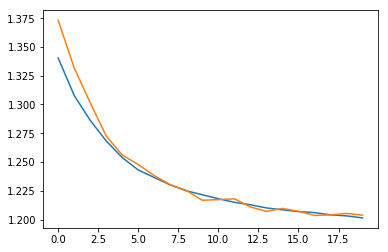

In [32]:
try:
    history = model.fit([a_movieid, a_userid], a_y, 
                         nb_epoch=20,
                         batch_size=1024,
                         validation_data=([b_movieid, b_userid], b_y))
    plot(history.history['loss'])
    plot(history.history['val_loss'])
except KeyboardInterrupt:
    pass

In [ ]:

# This is the number that matters. It's the held out 
# test set score. Note the + 1, because np.argmax will
# go from 0 to 4, while our ratings go 1 to 5.
metrics.mean_absolute_error(
    np.argmax(b_y, 1)+1, 
    np.argmax(model.predict([b_movieid, b_userid]), 1)+1)

In [ ]:
# For comparison's sake, here's the score on the training set.
metrics.mean_absolute_error(
    np.argmax(a_y, 1)+1, 
    np.argmax(model.predict([a_movieid, a_userid]), 1)+1)